In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import subprocess
import numpy as np
import glob

In [2]:
def savefig(name, **kwargs):
    fn = "{}.pdf".format(name)
    pp = PdfPages(fn)
    pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)
    pp.close()
    print("saving and cropping ", fn)
    subprocess.run(["pdfcrop", fn, fn])

In [3]:
# us -> MHz
reference_frequency_per_time_unit = 2.0E3
TRANSITION_LATENCY = "Transition latency [µs]"
WAIT_LATENCY = "Time since last frequency change [us]"
WAIT_LATENCY_BETWEEN_RUNS = "Time between detection of last frequency\nchange from source to target frequency [µs]"
SOURCE_FREQUENCY = "Source Frequency [GHz]"
TARGET_FREQUENCY = "Target Frequency [GHz]"
FREQ_TRANSITION = "Frequency transition [GHz]"

In [4]:
folder = "results/hati"
files_matcher = f"./{folder}/*.txt"

processed_data = pd.DataFrame()
all_data = pd.DataFrame()

for file in glob.glob(files_matcher):
    frequencies, slug = os.path.basename(file).split('-')
    start, target = frequencies.split('_')
    start_ghz = int(start) / 1e6
    target_ghz = int(target) / 1e6

    # filter out too high turbo frequencies
    if target_ghz > 2.9 or start_ghz > 2.9:
        continue

    try:
        data = pd.read_csv(file, sep='\t',comment='#')
        print(data)
    except:
        continue
    data[TRANSITION_LATENCY] = data["Change time (with write) [cycles]"] / reference_frequency_per_time_unit
    data[WAIT_LATENCY] = data["Time since last frequency change [cycles]"] / reference_frequency_per_time_unit
    data["Change time [us]"] = data["Change time [cycles]"] / reference_frequency_per_time_unit
    data["Change time (with write) [us]"] = data["Change time (with write) [cycles]"] / reference_frequency_per_time_unit
    data["Write cost [us]"] = data["Write cost [cycles]"] / reference_frequency_per_time_unit
    data["second_change [us]"] = (data["Time since last frequency change request [cycles]"] - data["Time since last frequency change [cycles]"] + data["Change time (with write) [cycles]"]) / reference_frequency_per_time_unit
    data["second_validation_interval [us]"] = (data["Time since last frequency change [cycles]"] - data["Change time (with write) [cycles]"]) / reference_frequency_per_time_unit - data["Wait time [us]"]
    data[WAIT_LATENCY_BETWEEN_RUNS] = data["Detected frequency change timestamp [cycles]"].diff() / reference_frequency_per_time_unit

    # filter invalid measurement values
    data=data[data[TRANSITION_LATENCY]>0]
    # discard the first row
    data = data.iloc[1:]

    processed_data = pd.concat([processed_data, pd.DataFrame([
        {'valids': len(data),
         'median_<1ms': np.median(data[data[WAIT_LATENCY] < 1000][TRANSITION_LATENCY].quantile(0.5)),
         'median_>1ms': np.median(data[data[WAIT_LATENCY] > 1000][TRANSITION_LATENCY].quantile(0.5)),
         'median': np.median(data[TRANSITION_LATENCY].quantile(0.5)),
         '1percentQuantile': data[TRANSITION_LATENCY].quantile(0.01),
         '95percentQuantile': data[TRANSITION_LATENCY].quantile(0.95),
         '99percentQuantile': data[TRANSITION_LATENCY].quantile(0.99),
         SOURCE_FREQUENCY: start_ghz,
         TARGET_FREQUENCY: target_ghz}
    ])])

    data[SOURCE_FREQUENCY] = start_ghz
    data[TARGET_FREQUENCY] = target_ghz
    data[FREQ_TRANSITION] = f"{start_ghz}GHz -> {target_ghz}GHz"
    all_data = pd.concat([all_data, data])

processed_data

     Change time (with write) [cycles]  Change time [cycles]  \
0                              1014672                957596   
1                              1393902               1369920   
2                               958914                933810   
3                              1704904               1677266   
4                              1585844               1561330   
..                                 ...                   ...   
995                            1184512               1160524   
996                            2094392               2067212   
997                            1471488               1447976   
998                            1317342               1293074   
999                            1342870               1318174   

     Write cost [cycles]  Wait time [us]  \
0                  57076            3567   
1                  23982            4812   
2                  25104             907   
3                  27638            3036   
4          

,valids,median_<1ms,median_>1ms,median,1percentQuantile,95percentQuantile,99percentQuantile,Source Frequency [GHz],Target Frequency [GHz]
0,883,590.2645,742.0310,731.4150,206.18594,1005.18770,1085.97518,1.6,2.4
0,999,412.8940,784.2995,765.9240,194.72758,1081.07580,1885.65902,1.3,2.2
0,999,455.8000,591.0400,590.7070,109.91734,649.40970,696.95598,1.5,0.9
0,922,474.5110,589.6830,589.4835,99.12539,641.66755,681.67930,1.7,1.6
0,994,496.7170,591.5320,591.3965,106.81548,642.05460,685.83933,1.5,1.6
...,...,...,...,...,...,...,...,...,...
0,999,365.4790,817.0645,794.8010,191.51490,1063.46550,1122.28874,1.1,2.1
0,989,492.6920,587.1860,587.0470,103.93944,640.27140,712.18908,2.9,2.1
0,985,448.5690,588.3600,587.7790,106.61952,649.27080,1389.23672,2.0,1.8
0,933,506.0425,590.4740,590.0670,102.75276,649.06600,710.15088,2.1,0.8


In [5]:
all_data.reset_index()
all_data

,Change time (with write) [cycles],Change time [cycles],Write cost [cycles],Wait time [us],Time since last frequency change request [cycles],Time since last frequency change [cycles],Detected frequency change timestamp [cycles],Transition latency [µs],Time since last frequency change [us],Change time [us],Change time (with write) [us],Write cost [us],second_change [us],second_validation_interval [us],Time between detection of last frequency\nchange from source to target frequency [µs],Source Frequency [GHz],Target Frequency [GHz],Frequency transition [GHz]
1,1393902,1369920,23982,4812,11099194,11315538,1122197303652401,696.951,5657.769,684.960,696.951,11.991,588.779,148.818,6.358583e+03,1.6,2.4,1.6GHz -> 2.4GHz
2,958914,933810,25104,907,3289412,3069936,1122197308121343,479.457,1534.968,466.905,479.457,12.552,589.195,148.511,2.234471e+03,1.6,2.4,1.6GHz -> 2.4GHz
3,1704904,1677266,27638,3036,7114494,8074904,1122197317161267,852.452,4037.452,838.633,852.452,13.819,372.247,149.000,4.519962e+03,1.6,2.4,1.6GHz -> 2.4GHz
4,1585844,1561330,24514,4996,10930336,11875216,1122197329898133,792.922,5937.608,780.665,792.922,12.257,320.482,148.686,6.368433e+03,1.6,2.4,1.6GHz -> 2.4GHz
5,1414046,1390640,23406,2463,6191478,6635936,1122197337728279,707.023,3317.968,695.320,707.023,11.703,484.794,147.945,3.915073e+03,1.6,2.4,1.6GHz -> 2.4GHz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1174674,1156090,18584,4240,10153902,9857738,1124943183457499,587.337,4928.869,578.045,587.337,9.292,735.419,101.532,5.798075e+03,2.6,1.8,2.6GHz -> 1.8GHz
993,1181376,1165530,15846,4037,9584724,9463326,1124943194489995,590.688,4731.663,582.765,590.688,7.923,651.387,103.975,5.516248e+03,2.6,1.8,2.6GHz -> 1.8GHz
995,1176244,1159824,16420,120,2358478,1610000,1124943208598745,588.122,805.000,579.912,588.122,8.210,962.361,96.878,5.624716e+11,2.6,1.8,2.6GHz -> 1.8GHz
998,989240,971414,17826,4914,11727682,11024214,1124943240161615,494.620,5512.107,485.707,494.620,8.913,846.354,103.487,5.624716e+11,2.6,1.8,2.6GHz -> 1.8GHz


In [6]:
all_data_random_sample = all_data.sample(frac=.10)
all_data_random_sample

,Change time (with write) [cycles],Change time [cycles],Write cost [cycles],Wait time [us],Time since last frequency change request [cycles],Time since last frequency change [cycles],Detected frequency change timestamp [cycles],Transition latency [µs],Time since last frequency change [us],Change time [us],Change time (with write) [us],Write cost [us],second_change [us],second_validation_interval [us],Time between detection of last frequency\nchange from source to target frequency [µs],Source Frequency [GHz],Target Frequency [GHz],Frequency transition [GHz]
834,1094222,1076284,17938,3817,8914420,8946156,1123854953152153,547.111,4473.078,538.142,547.111,8.969,531.243,108.967,5117.533,2.2,2.1,2.2GHz -> 2.1GHz
609,259368,237078,22290,2908,7733150,6318930,1123455711284399,129.684,3159.465,118.539,129.684,11.145,836.794,121.781,4234.688,2.1,0.9,2.1GHz -> 0.9GHz
63,1859524,1697852,161672,2268,6152912,6828628,1120501224838301,929.762,3414.314,848.926,929.762,80.836,591.904,216.552,4105.415,1.0,2.8,1.0GHz -> 2.8GHz
447,1182140,1157758,24382,1947,5667132,5269576,1125753005746519,591.070,2634.788,578.879,591.070,12.191,789.848,96.718,3580.859,2.9,1.5,2.9GHz -> 1.5GHz
445,1042474,1025382,17092,2874,7442700,6983672,1125752989730987,521.237,3491.836,512.691,521.237,8.546,750.751,96.599,4401.238,2.9,1.5,2.9GHz -> 1.5GHz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,1184330,1168324,16006,1153,4024420,3682584,1124854039254891,592.165,1841.292,584.162,592.165,8.003,763.083,96.127,2865.325,2.6,0.8,2.6GHz -> 0.8GHz
991,1434944,1410834,24110,1670,4794226,5070808,1122205152103351,717.472,2535.404,705.417,717.472,12.055,579.181,147.932,3224.611,1.6,2.4,1.6GHz -> 2.4GHz
486,1304616,1155402,149214,4899,11098982,11505068,1120701353059131,652.308,5752.534,577.701,652.308,74.607,449.265,201.226,6337.746,1.1,1.8,1.1GHz -> 1.8GHz
60,989830,951252,38578,4117,9957876,9749912,1119918007318181,494.915,4874.956,475.626,494.915,19.289,598.897,263.041,5572.944,0.8,2.8,0.8GHz -> 2.8GHz


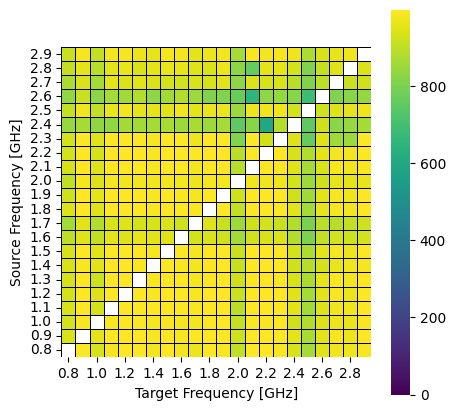

In [7]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="valids"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
# savefig(f"../../thesis/fig/ftalat_valids_hati")

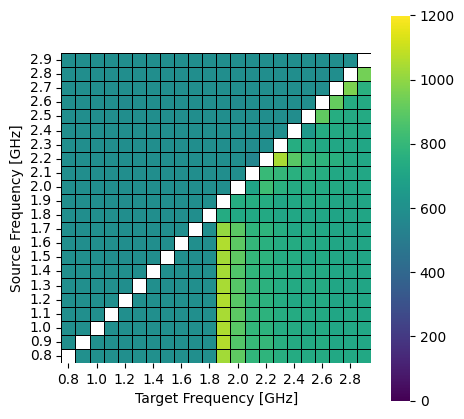

In [8]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="median"), vmin=0, vmax=1200, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
# savefig(f"../../thesis/fig/ftalat_median_hati")

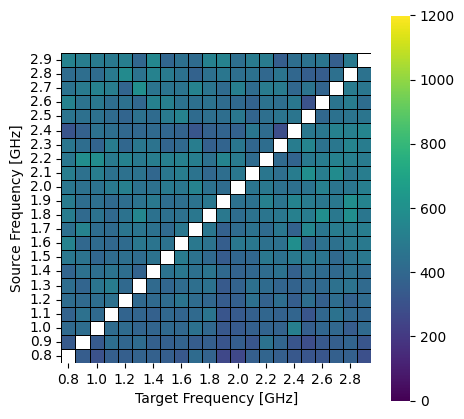

In [9]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="median_<1ms"), vmin=0, vmax=1200, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
# savefig(f"../../thesis/fig/ftalat_median_<1ms_hati")

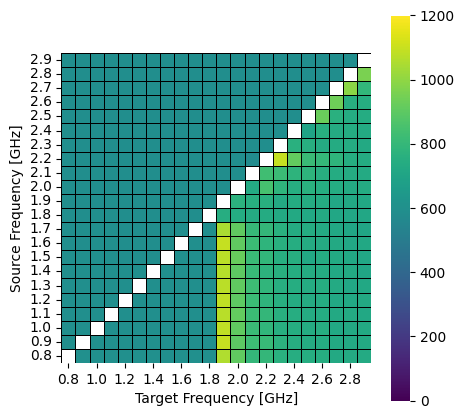

In [10]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="median_>1ms"), vmin=0, vmax=1200, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
# savefig(f"../../thesis/fig/ftalat_median_>1ms_hati")

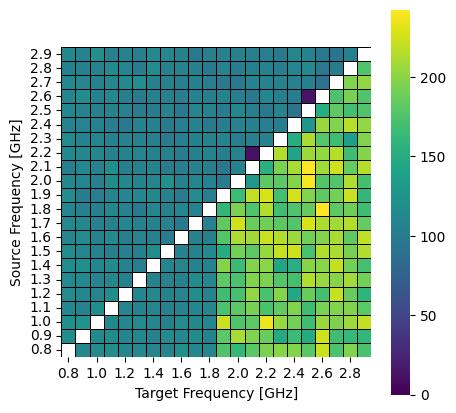

In [11]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="1percentQuantile"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
# savefig(f"../../thesis/fig/ftalat_1percentQuantile_hati")

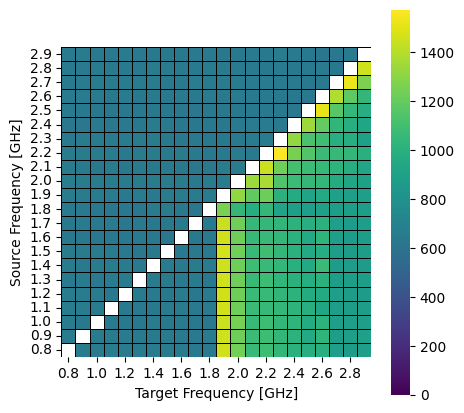

In [12]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="95percentQuantile"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
# savefig(f"../../thesis/fig/ftalat_95percentQuantile_hati")

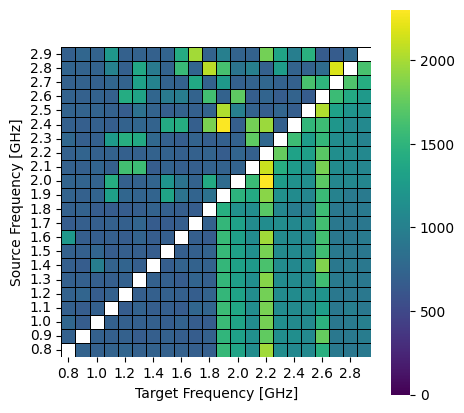

In [13]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="99percentQuantile"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
# savefig(f"../../thesis/fig/ftalat_99percentQuantile_hati")

In [14]:
col_order = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]

In [15]:
filtered_data = all_data
filtered_data = filtered_data[filtered_data[SOURCE_FREQUENCY] == 1.2]
filtered_data = filtered_data[filtered_data[TARGET_FREQUENCY] >= 1.8]
filtered_data = filtered_data[filtered_data[TARGET_FREQUENCY] <= 2.5]
filtered_data

,Change time (with write) [cycles],Change time [cycles],Write cost [cycles],Wait time [us],Time since last frequency change request [cycles],Time since last frequency change [cycles],Detected frequency change timestamp [cycles],Transition latency [µs],Time since last frequency change [us],Change time [us],Change time (with write) [us],Write cost [us],second_change [us],second_validation_interval [us],Time between detection of last frequency\nchange from source to target frequency [µs],Source Frequency [GHz],Target Frequency [GHz],Frequency transition [GHz]
1,564664,533328,31336,4812,11151448,10563494,1121033568181519,282.332,5281.747,266.664,282.332,15.668,576.309,187.415,5974.085,1.2,2.3,1.2GHz -> 2.3GHz
2,1731182,1701796,29386,907,3367362,3920022,1121033573507961,865.591,1960.011,850.898,865.591,14.693,589.261,187.420,2663.221,1.2,2.3,1.2GHz -> 2.3GHz
3,1599726,1569840,29886,3036,6877180,8046680,1121033582212481,799.863,4023.340,784.920,799.863,14.943,215.113,187.477,4352.260,1.2,2.3,1.2GHz -> 2.3GHz
4,1417600,1389040,28560,4996,11047052,11785438,1121033594904279,708.800,5892.719,694.520,708.800,14.280,339.607,187.919,6345.899,1.2,2.3,1.2GHz -> 2.3GHz
5,1398886,1370706,28180,2463,6485242,6699828,1121033603015497,699.443,3349.914,685.353,699.443,14.090,592.150,187.471,4055.609,1.2,2.3,1.2GHz -> 2.3GHz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1189640,1160254,29386,120,1754066,1804832,1121023750079735,594.820,902.416,580.127,594.820,14.693,569.437,187.596,1596.640,1.2,2.1,1.2GHz -> 2.1GHz
996,1524152,1494522,29630,2891,7333156,7680152,1121023759192127,762.076,3840.076,747.261,762.076,14.815,588.578,187.000,4556.196,1.2,2.1,1.2GHz -> 2.1GHz
997,1468460,1440428,28032,3402,8211458,8646930,1121023769116349,734.230,4323.465,720.214,734.230,14.016,516.494,187.235,4962.111,1.2,2.1,1.2GHz -> 2.1GHz
998,1177626,1149200,28426,4914,11278476,11380962,1121023781817451,588.813,5690.481,574.600,588.813,14.213,537.570,187.668,6350.551,1.2,2.1,1.2GHz -> 2.1GHz


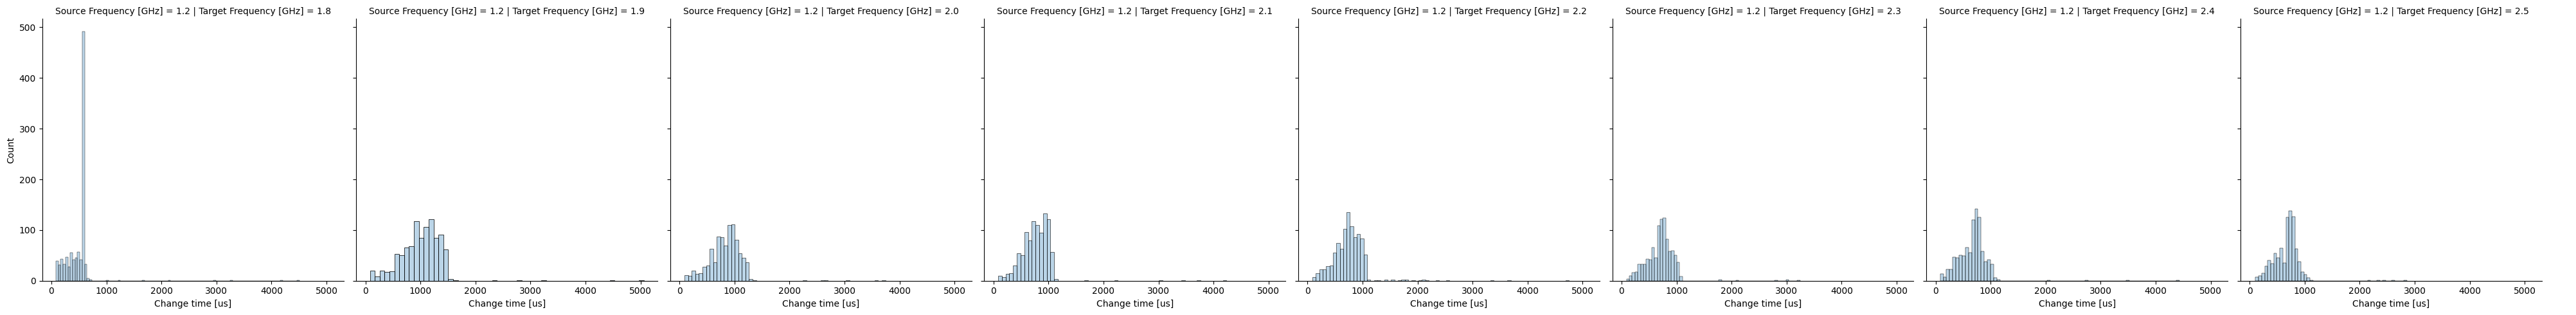

In [16]:
g = sns.FacetGrid(filtered_data, col=TARGET_FREQUENCY,  row=SOURCE_FREQUENCY, height=5, col_order=col_order)
g.map(sns.histplot, "Change time [us]", alpha=0.3)
g.add_legend()

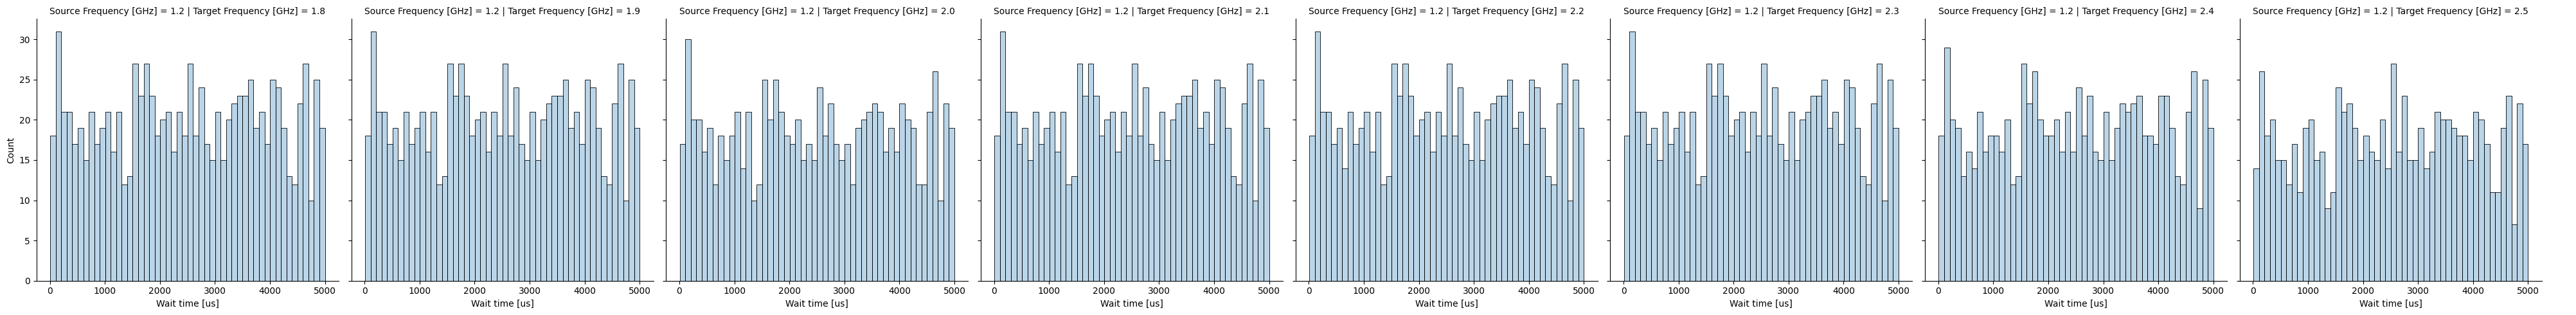

In [17]:
g = sns.FacetGrid(filtered_data, col=TARGET_FREQUENCY,  row=SOURCE_FREQUENCY, height=5, col_order=col_order)
g.map(sns.histplot, "Wait time [us]", alpha=0.3, binwidth=100)
g.add_legend()

saving and cropping  ../../thesis/fig/ftalat_scatter_wait_transition_latency_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_scatter_wait_transition_latency_hati.pdf'.


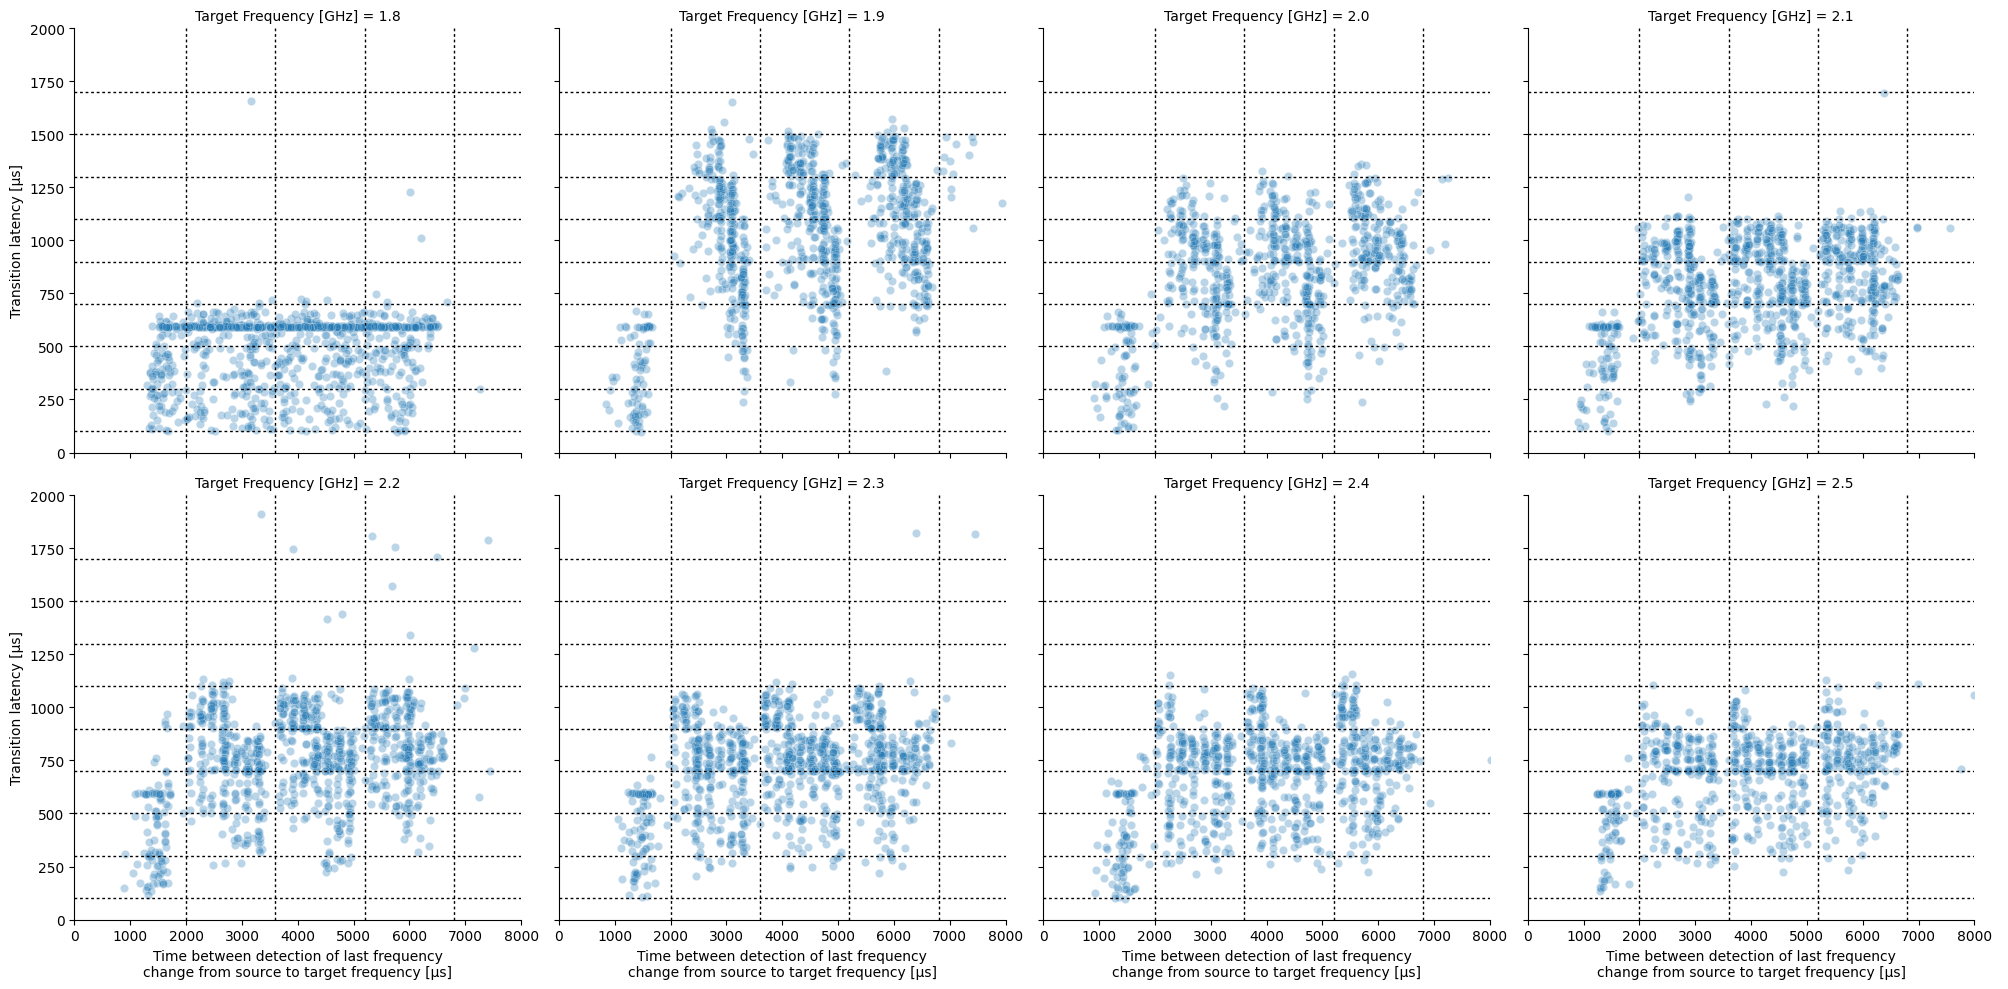

In [18]:
g = sns.FacetGrid(filtered_data, col=TARGET_FREQUENCY, height=5, col_order=col_order, ylim=(0,2000), xlim=(0, 8000), col_wrap=4)
g.map(sns.scatterplot, WAIT_LATENCY_BETWEEN_RUNS, TRANSITION_LATENCY, alpha=0.3)
g.add_legend()
buckets = [2000+ 1600*i for i in range(4)]
for axi in g.axes:
    for i in buckets:
        axi.axvline(x=i, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=900, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=900+200, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=900+400, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=900+600, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=900+800, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=900-200, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=900-400, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=900-600, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=900-800, color='black', dashes=[2], linewidth=1)
savefig(f"../../thesis/fig/ftalat_scatter_wait_transition_latency_hati")

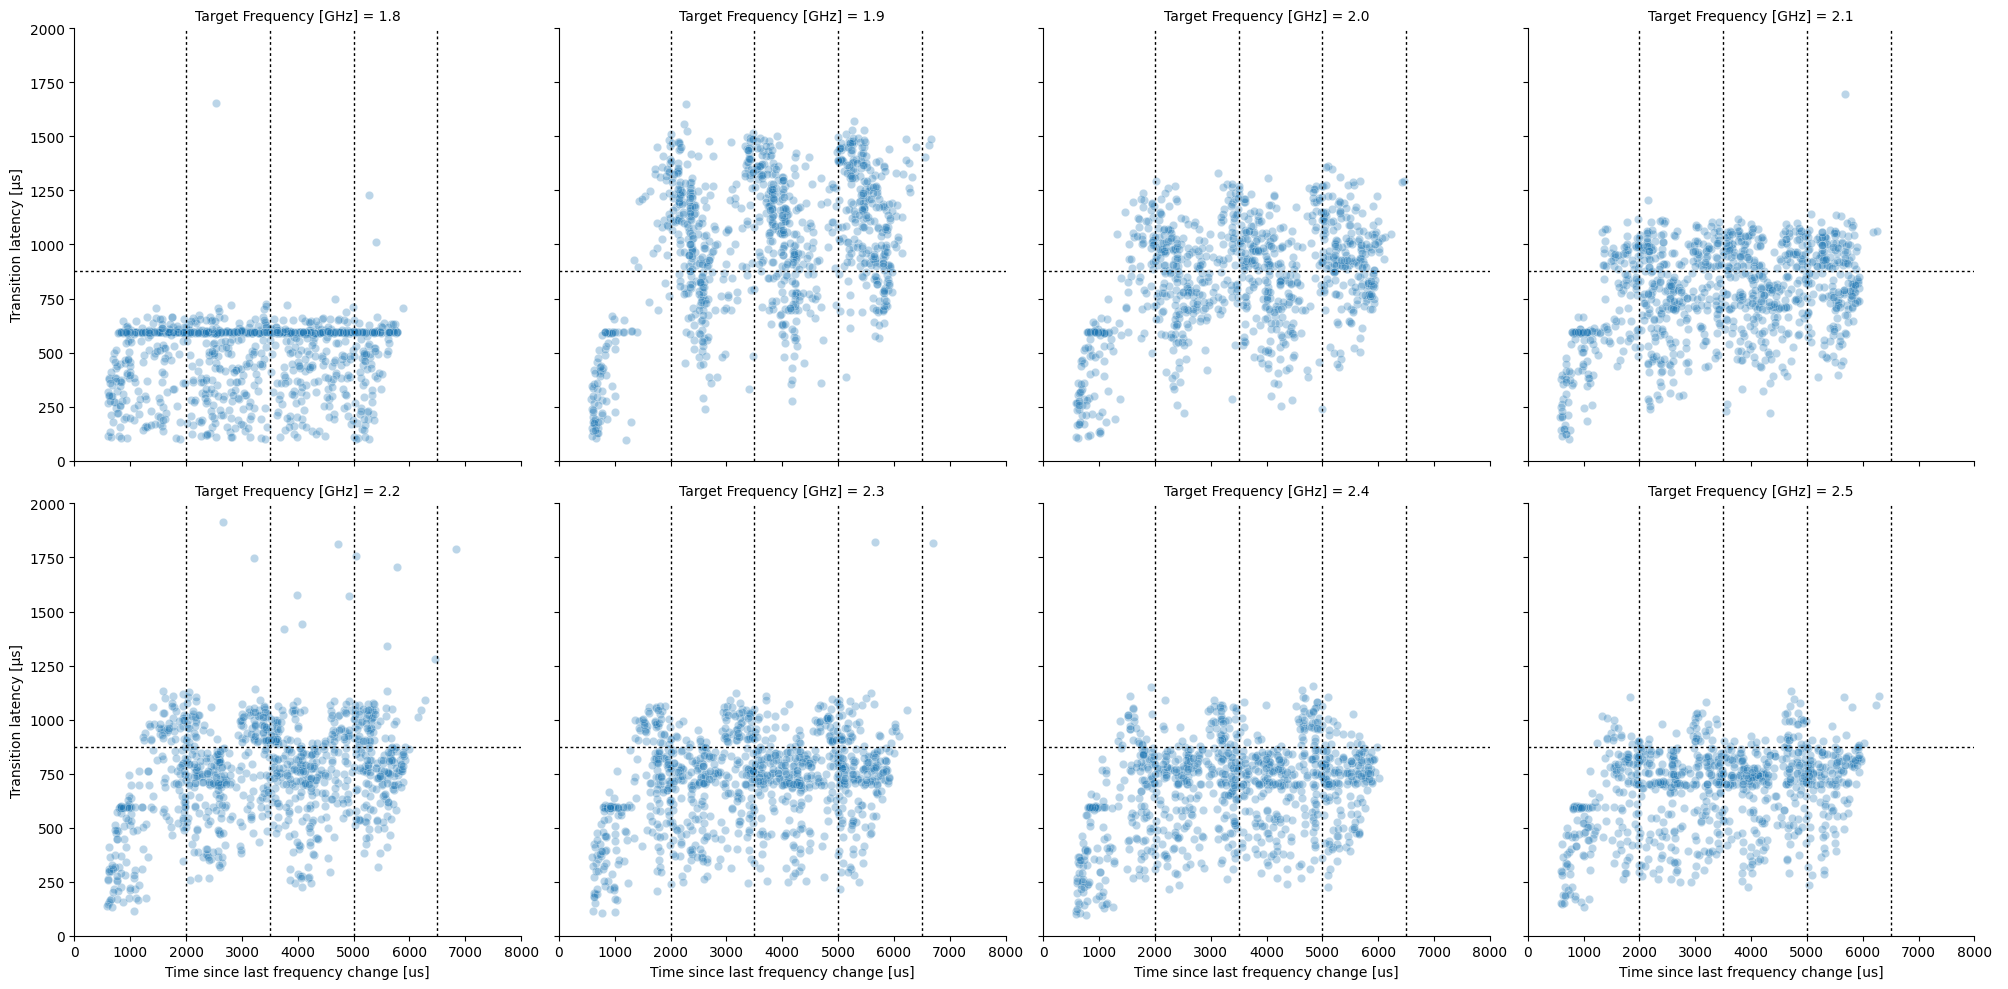

In [19]:
g = sns.FacetGrid(filtered_data, col=TARGET_FREQUENCY, height=5, col_order=col_order, ylim=(0,2000), xlim=(0, 8000), col_wrap=4)
g.map(sns.scatterplot, WAIT_LATENCY, TRANSITION_LATENCY, alpha=0.3)
g.add_legend()
buckets = [2000, 3500, 5000, 6500]
for axi in g.axes:
    for i in buckets:
        axi.axvline(x=i, color='black', dashes=[2], linewidth=1)
    axi.axhline(y=875, color='black', dashes=[2], linewidth=1)
# savefig(f"../../thesis/fig/ftalat_scatter_wait_transition_latency_hati")